In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from ast import literal_eval as make_tuple

from scipy import integrate

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pathlib import Path
Path('../fig').mkdir(parents=True, exist_ok=True)

In [2]:
def plot_parameters():
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["figure.figsize"] = [10, 10]  # plot image size

    SMALL_SIZE = 20
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 35

    plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc("xtick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("ytick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)


    return SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE


In [3]:
def luminosity_distance(redshift):
    """
    Compute luminosity distance as function of the redshift

    Parameters
    ----------
        redshift: scalar
            Cosmological redshift value

    Returns
    -------
        scalar: Returns luminosity distance relative to given redshift
    """

    # cosmological constants
    # values from https://arxiv.org/pdf/1807.06209.pdf
    h = 0.6796
    H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
    clight = 2.99792458e8  # speed of lightm s**-1
    Dist_H = clight / H_0  # Huble distance

    Omega_M = 0.315
    Omega_Λ = 1 - Omega_M
    Omega_K = 0.0

    def Ez(z): return 1 / np.sqrt(Omega_M * (1 + z)
                                  ** 3 + Omega_K * (1 + z)**2 + Omega_Λ)
    Dist_C = Dist_H * integrate.quad(Ez, 0, redshift)[0]
    Dist_L = (1 + redshift) * Dist_C

    return Dist_L

In [5]:
def plot_settings(ax, frame, mass_ratio):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(bottom = 1e-4)
    ax.set_ylabel(r'redshift, $z$')
#     ax.set_xlabel(r'final mass $[M_\odot]$'+f'({frame} frame)')

    axx = ax.twinx()
    mn, mx = ax.get_ylim()
    axx.set_yscale("log")
    axx.set_ylim(luminosity_distance(mn) * 1e-3,
                 luminosity_distance(mx) * 1e-3)
    axx.set_ylabel(f"$D_L$ [Gpc]")

    
    ## set y ticks    
    x_major = mpl.ticker.LogLocator(base = 10.0, numticks =10)
    x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 20)
    
    ax.xaxis.set_major_locator(x_major)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 5)
    y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)

    ax.yaxis.set_major_locator(y_major)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    axx.yaxis.set_major_locator(y_major)
    axx.yaxis.set_minor_locator(y_minor)
    axx.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    

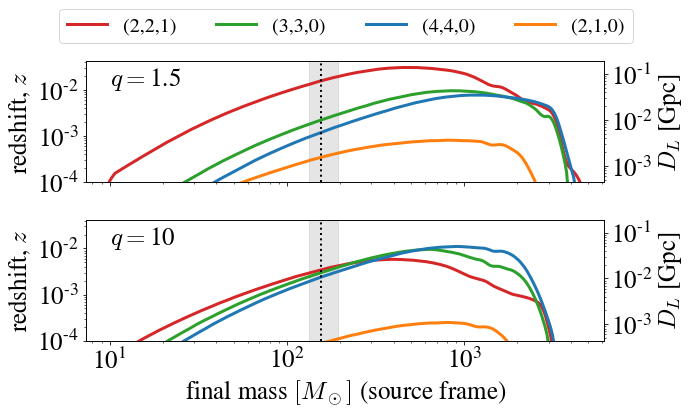

In [12]:
df_ray = pd.read_csv('../data/two_modes_horizons_LIGO.dat', sep='\t')
df_ray['modes'] = df_ray.apply(lambda row: make_tuple(row.modes)[1][1]+make_tuple(row.modes)[1][3]+make_tuple(row.modes)[1][5], axis=1)

plot_parameters()
fig, ax = plt.subplots(2, sharex = True, sharey = True, figsize = [10,6])
i = 0
colors = {
    '221': 'tab:red',
    '330': 'tab:green',
    '440': 'tab:blue',
    '210': 'tab:orange',
}
for q in df_ray.mass_ratio.unique():
    df_q = df_ray[df_ray.mass_ratio == q]
    for mode in df_ray.modes.unique():
        df_plot = df_q[df_q.modes == mode]
        
        ax[i].loglog(df_plot.masses, savgol_filter(df_plot.redshifts,5,1),
                     label = f'({mode[0]},{mode[1]},{mode[2]})', color = colors[mode], lw = 3)
#         ax[i].loglog(df_plot.masses, df_plot.redshifts, color = 'black', ls = ':')
        
    ymin, ymax = ax[i].get_ylim()
    if q == 10.0:
        q = round(q)
    ax[i].text(10, ymax - (ymax - ymin)/5, r"$q = $"+f'{q}', verticalalignment = 'top', fontsize = 25)
#     ax[i].axhline(0.03)
    ax[i].axvline(156.3, color = 'k', ls = ':', lw = 2)
    ax[i].axvspan(156.3+36.8, 156.3-22.4, color = 'k', alpha = 0.1)
    plot_settings(ax[i], 'source', q)
    
    i += 1
ax[1].set_xlabel(r'final mass $[M_\odot]$ (source frame)')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=10)
fig.tight_layout(rect=(0,0,1,0.9))
plt.savefig(f'../fig/rayleigh_horizon_LIGO.pdf')


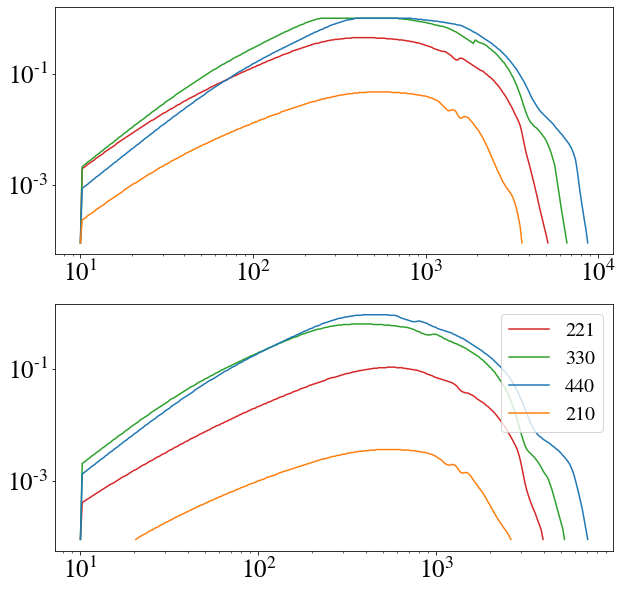

In [26]:
df_ray_crit = pd.read_csv('../data/two_modes_horizons_critical.dat', sep='\t')
df_ray_crit['modes'] = df_ray_crit.apply(lambda row: make_tuple(row.modes)[1][1]+make_tuple(row.modes)[1][3]+make_tuple(row.modes)[1][5], axis=1)
df_ray = df_ray[df_ray.detector == 'LIGO']
fig, ax = plt.subplots(2, figsize = [10,10])
i = 0
colors = {
    '221': 'tab:red',
    '330': 'tab:green',
    '440': 'tab:blue',
    '210': 'tab:orange',
}
for q in df_ray_crit.mass_ratio.unique():
    df_q_crit = df_ray_crit[df_ray_crit.mass_ratio == q]
    for mode in df_ray_crit.modes.unique():
        df_plot_crit = df_q_crit[df_q_crit.modes == mode]
        ax[i].loglog(df_plot_crit.masses, df_plot_crit.redshifts, label = mode, color = colors[mode])
    i += 1
plt.legend()


In [5]:
def import_data_bayes(mass_ratio, mode):
    """Import data computed from scr/rayleigh_criterion_two_modes.py
    
    Parameters
    ----------
    detector : str
        Gravitational wave detector name. Must be {'LIGO', 'LISA',
        'CE' = 'CE2silicon', 'CE2silica', 'ET'}.
    mass_ratio : TYPE
        Binary black hole mass ratio. mass_ratio >= 1. This is used to
        determine the QNM parameters.
    
    Returns
    -------
    Pandas DataFrame
        Return DataFrame with the data
    """
    columns = ('mass',
               'redshift',
              )

    df = pd.read_csv(f'../data/bayes/horizon_{mass_ratio}_data_220_{mode}_model_220.dat', delimiter = "\t", comment="#", names=columns)
    df['modes'] = [mode]*len(df.mass)
    df['mass_ratio'] = [mass_ratio]*len(df.mass)
    return df

In [6]:
bayes = pd.DataFrame()
for q in [1.5, 10]:
    for mode in ['221', '330', '440', '210']:
        bayes = bayes.append(import_data_bayes(q, mode))


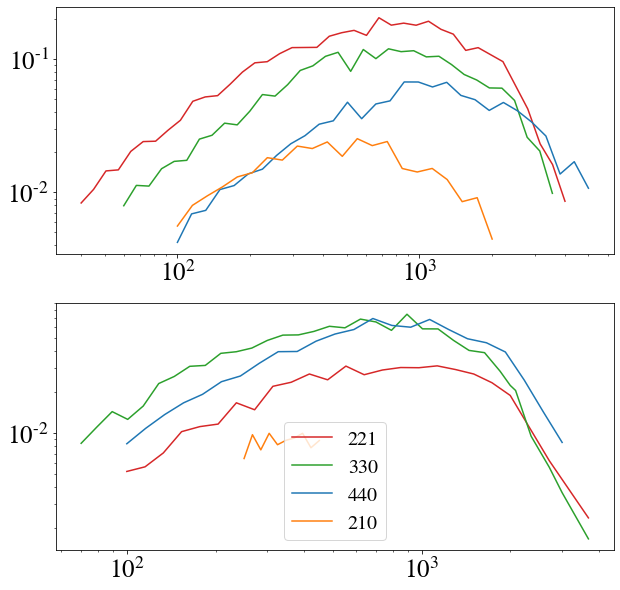

In [7]:
fig, ax = plt.subplots(2, figsize = [10,10])
i = 0
for q in bayes.mass_ratio.unique():
    df_q = bayes[bayes.mass_ratio == q]
    for mode in bayes.modes.unique():
        df_plot = df_q[df_q.modes == mode]
        df_plot = df_plot.sort_values(by=['mass'])
        ax[i].loglog(df_plot.mass, df_plot.redshift, label = mode, color = colors[mode])
    i += 1
plt.legend()

1.5
0.4453072062801279
12.674541298575765
7.77613139769548
0.4907635744505235

10.0
0.31849663011485846
7.741275972132386
6.168613317212389
2.5403612109650395



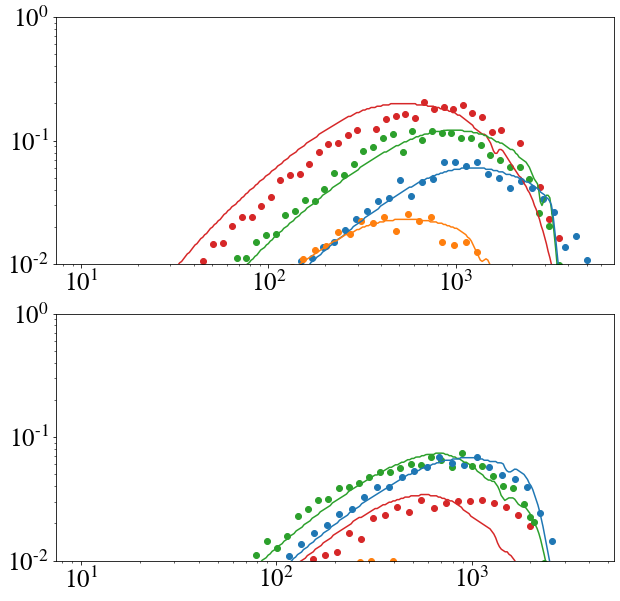

In [8]:
from scipy import interpolate
fig, ax = plt.subplots(2, figsize = [10,10])
i = 0
for q in df_ray.mass_ratio.unique():
    df_q_ray = df_ray[df_ray.mass_ratio == q]
    df_q_ray_crit = df_ray_crit[df_ray_crit.mass_ratio == q]
    df_q_bayes = bayes[bayes.mass_ratio == q]
    print(q)
    for mode in df_ray.modes.unique():
        df_plot_ray = df_q_ray[df_q_ray.modes == mode]
        df_plot_ray_crit = df_q_ray_crit[df_q_ray_crit.modes == mode]
        df_plot_bayes = df_q_bayes[df_q_bayes.modes == mode]
        f_ray = interpolate.interp1d(df_plot_ray.masses, df_plot_ray.redshifts)
        f_ray_crit = interpolate.interp1d(df_plot_ray_crit.masses, df_plot_ray_crit.redshifts)
        ax[i].scatter(df_plot_bayes.mass, df_plot_bayes.redshift, label = mode, color = colors[mode])
#         ax[i].loglog(df_plot_ray.masses, (f_ray(df_plot_ray.masses)*2+ f_ray_crit(df_plot_ray.masses)/2), label = mode, color = colors[mode])
#         ax[i].loglog(df_plot_ray.masses, df_plot_ray.redshifts, label = mode, color = colors[mode])
#         ax[i].loglog(df_plot_ray_crit.masses, df_plot_ray_crit.redshifts, label = mode, color = colors[mode])


        logmass = np.log10(df_plot_bayes["mass"].values)
        logz = np.log10(df_plot_bayes["redshift"].values)
        coeffs = np.polyfit(logmass, logz, deg=3)
        # print(q)
        # print(mode)
        # print(coeffs)
        poly = np.poly1d(coeffs)
        xnew = np.logspace(min(logmass),max(logmass), 100)

#         ax[i].plot(
#             xnew,
#             10**(poly(np.log10(xnew))),
#             lw=3,
#             color=colors[mode],
#             ls='-',
#             alpha=1,
#         )
        max_bayes = max(10**(poly(np.log10(xnew))))
        if mode == '221' or mode == '210':
            df_plot_ray = df_plot_ray_crit
        max_ray = max(df_plot_ray.redshifts)
        refactor = max_bayes/max_ray
        print(refactor)
        ax[i].loglog(df_plot_ray.masses*(1+df_plot_ray.redshifts*refactor), df_plot_ray.redshifts*refactor, label = mode, color = colors[mode])

    ax[i].set_ylim(1e-2, 1)
    print('')
        
    i += 1

1.5

 221
a =  5.975058173871653
b =  0.0

 330
a =  12.327499135372179
b =  0.0

 440
a =  7.7656313401349735
b =  0.0

 210
a =  25.83522599786161
b =  0.0

10.0

 221
a =  5.033691873313811
b =  0.0

 330
a =  8.050030925805423
b =  0.0

 440
a =  6.043348530130178
b =  0.0

 210
a =  49.82414965677225
b =  0.0



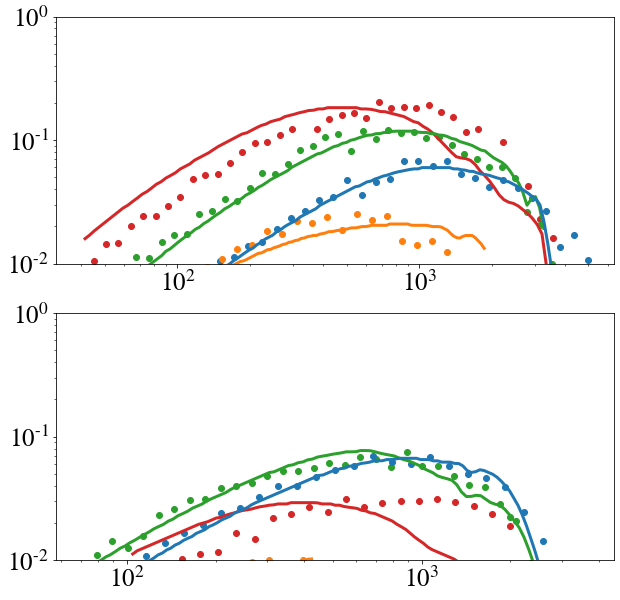

In [9]:
import scipy.optimize as optimize
import lmfit

fig, ax = plt.subplots(2, figsize = [10,10])
i = 0
scale_factors = {}
for q in df_ray.mass_ratio.unique():
    scale_factors[q] = {}
    df_q_ray = df_ray[df_ray.mass_ratio == q]
    df_q_ray_crit = df_ray_crit[df_ray_crit.mass_ratio == q]
    df_q_bayes = bayes[bayes.mass_ratio == q]
    print(q)
    for mode in df_ray.modes.unique():
        df_plot_ray = df_q_ray[df_q_ray.modes == mode]
        df_plot_ray_crit = df_q_ray_crit[df_q_ray_crit.modes == mode]
        df_plot_bayes = df_q_bayes[df_q_bayes.modes == mode]
        f_ray = interpolate.interp1d(df_plot_ray.masses, df_plot_ray.redshifts)
        f_ray_crit = interpolate.interp1d(df_plot_ray_crit.masses, df_plot_ray_crit.redshifts)
        ax[i].scatter(df_plot_bayes.mass, df_plot_bayes.redshift, label = mode, color = colors[mode])

        logmass = np.log10(df_plot_bayes["mass"].values)
        logz = np.log10(df_plot_bayes["redshift"].values)
        coeffs = np.polyfit(logmass, logz, deg=3)

        poly = np.poly1d(coeffs)
        logmass_ray = np.log10(df_plot_ray.masses.values)
        xmin = max((min(logmass_ray), min(logmass)*1.01))
        xmax = min((max(logmass_ray), max(logmass)*0.99))
        
        xnew = np.logspace(xmin,xmax, 100)
        ynew = 10**(poly(np.log10(xnew)))
        
        def refactorize(params, x, ydata):
            factor =  params['a'] #+  params['b']*x
            return factor*f_ray(x) - ydata


        params = lmfit.Parameters()
        
        params.add('a', 1.)
        params.add('b', 0.)
        
        minimized = lmfit.minimize(refactorize, params, args=(xnew, ynew))
#         lmfit.report_fit(fitted_params)
        a = minimized.params['a'].value
        b = minimized.params['b'].value
        
        scale_factors[q][mode] = {
            'a': a,
            'b': b,            
        }
        print('\n',mode)
        print('a = ', a) 
        print('b = ', b) 
        factor = a + b*xnew
        ax[i].loglog(xnew, factor*f_ray(xnew), label = mode, color = colors[mode], lw = 3)

    ax[i].set_ylim(1e-2, 1)
    print('')
        
    i += 1

In [10]:
def plot_parameters():
    plt.rcParams["mathtext.fontset"] = "cm"
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["figure.figsize"] = [20, 9]  # plot image size
    SMALL_SIZE = 20
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 32

    plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
    plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc("xtick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("ytick", labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc("figure", titlesize=BIGGER_SIZE)

    return SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE


In [11]:
def luminosity_distance(redshift):
    """
    Compute luminosity distance as function of the redshift

    Parameters
    ----------
        redshift: scalar
            Cosmological redshift value

    Returns
    -------
        scalar: Returns luminosity distance relative to given redshift
    """

    # cosmological constants
    # values from https://arxiv.org/pdf/1807.06209.pdf
    h = 0.6796
    H_0 = h * 100 * 1e+3  # Huble constant m s**-1 Mpc**-1
    clight = 2.99792458e8  # speed of lightm s**-1
    Dist_H = clight / H_0  # Huble distance

    Omega_M = 0.315
    Omega_Λ = 1 - Omega_M
    Omega_K = 0.0

    def Ez(z): return 1 / np.sqrt(Omega_M * (1 + z)
                                  ** 3 + Omega_K * (1 + z)**2 + Omega_Λ)
    Dist_C = Dist_H * integrate.quad(Ez, 0, redshift)[0]
    Dist_L = (1 + redshift) * Dist_C

    return Dist_L

In [12]:
def plot_settings(ax, frame, mass_ratio):
    ax.text(15, 4, r"$q = $"+f'{mass_ratio}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-1, 10)
    ax.set_xlim(10, 1e9)
    ax.set_ylabel(r'redshift, $z$')
    ax.set_xlabel(r'final mass $[M_\odot]$'+f'({frame} frame)')

    axx = ax.twinx()
    mn, mx = ax.get_ylim()
    axx.set_yscale("log")
    axx.set_ylim(luminosity_distance(mn) * 1e-3,
                 luminosity_distance(mx) * 1e-3)
    axx.set_ylabel("Luminosity distance [Gpc]")

    
    ## set y ticks    
    x_major = mpl.ticker.LogLocator(base = 10.0, numticks = 20)
    x_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 20)
    
    ax.xaxis.set_major_locator(x_major)
    ax.xaxis.set_minor_locator(x_minor)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 10)
    y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)

    ax.yaxis.set_major_locator(y_major)
    ax.yaxis.set_minor_locator(y_minor)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    axx.yaxis.set_major_locator(y_major)
    axx.yaxis.set_minor_locator(y_minor)
    axx.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    

In [13]:
def catalog_plot(ax, q, frame:str):
    catalog = pd.read_csv(
        "../data/catalog_bbh.csv").sort_values(by="final_mass_source")

    q_condition_up = (
        (catalog["mass_1_source"] + catalog["mass_1_source_upper"]
         ) / (catalog["mass_2_source"] + catalog["mass_2_source_lower"]
              ) > q)
    q_condition_low = (q > (
        catalog["mass_1_source"] + catalog["mass_1_source_lower"]
    ) / (catalog["mass_2_source"] + catalog["mass_2_source_upper"])
    )
    q_condition = q_condition_up & q_condition_low
    chi_eff_condition_up = (
        (catalog["chi_eff"] + catalog["chi_eff_upper"]
         ) > 0)
    chi_eff_condition_low = (0 > (
        catalog["chi_eff"] + catalog["chi_eff_lower"]
    ))
    chi_eff_condition = chi_eff_condition_up & chi_eff_condition_low
    compatible = catalog[q_condition & chi_eff_condition]

    extra = catalog[~(q_condition & chi_eff_condition)]
    if frame == 'detector':
        X_compatible = compatible["final_mass_source"] * (1 + compatible["redshift"])
        X_extra = extra["final_mass_source"] * (1 + extra["redshift"])
    else:
        X_compatible = compatible["final_mass_source"]
        X_extra = extra["final_mass_source"]
    ax.scatter(
        X_compatible,
        compatible["redshift"],
        color='gold',
        edgecolors="darkgoldenrod",
        lw=2,
        alpha=1,
        # label = "catalog",
        marker="o",
        s=50,
    )
    ax.scatter(
        X_extra,
        extra["redshift"],
        color='silver',
        edgecolors="dimgray",
        lw=2,
        alpha=1,
        # label = "catalog",
        marker="o",
        s=50,
        zorder=-10
    )

In [14]:
def plot_2_modes(data_frame):    
    plot_parameters()
    
    fig, axs = plt.subplots(2, 2, dpi = 400)
    
    plt.ylim(1e-1, 1e1)
    plt.xlim(1e1, 1e9)
    
    mass_ratios = [1.5, 10]
    frames = ['source', 'detector']
    detectors = [ 'ET', 'CE', 'LISA']
    modes = ['(2,2,1) II', '(3,3,0)', '(4,4,0)']#, '(2,1,0)']
    two_modes = [('(2,2,0)',mode) for mode in modes]

    colors = {
        '(2,2,1) II': 'tab:red',
        '(3,3,0)': 'tab:green',
        '(4,4,0)': 'tab:blue',
        '(2,1,0)': 'tab:orange',
    }
    linestyles = {
        'LIGO': '-',
        'ET': '--',
        'CE': ':',
        'LISA': '-',
    }
    i = 0 
    for mass_ratio in mass_ratios:
        j = 0 
        for frame in frames:
            catalog_plot(axs[i,j], mass_ratio, frame)
            plot_settings(axs[i,j], frame, mass_ratio)
                    
            for detector in detectors:
                for comb in two_modes:
                    condition = (data_frame.modes == f'{comb}')&(data_frame.detector == detector)&(data_frame.mass_ratio == mass_ratio)
                    df_plot = data_frame[condition]
                    mode = comb[1][1]+comb[1][3]+comb[1][5]
                    q = mass_ratio
                    if frame == 'detector':
                        masses_detector = df_plot.apply(lambda row: row.masses*(1+row.redshifts), axis=1)
                        df_plot = df_plot.assign(masses=masses_detector)

                    factor = scale_factors[q][mode]['a'] + scale_factors[q][mode]['b']*df_plot.masses
                    
                    if detector == 'LISA':
                        axs[i,j].plot(df_plot.masses, factor*df_plot.redshifts, color = colors[comb[1]], ls = linestyles[detector], lw = 3, label='(2,2,0) + '+comb[1][:7])
                    else:
                        axs[i,j].plot(df_plot.masses, factor*df_plot.redshifts, color = colors[comb[1]], ls = linestyles[detector], lw = 3)


            j += 1
        i += 1
        

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=10)
    fig.tight_layout(rect=(0,0,1,0.9))

    plt.savefig('../fig/rescaled_rayleigh_2modes.jpg', bbox_inches='tight', dpi = 400)

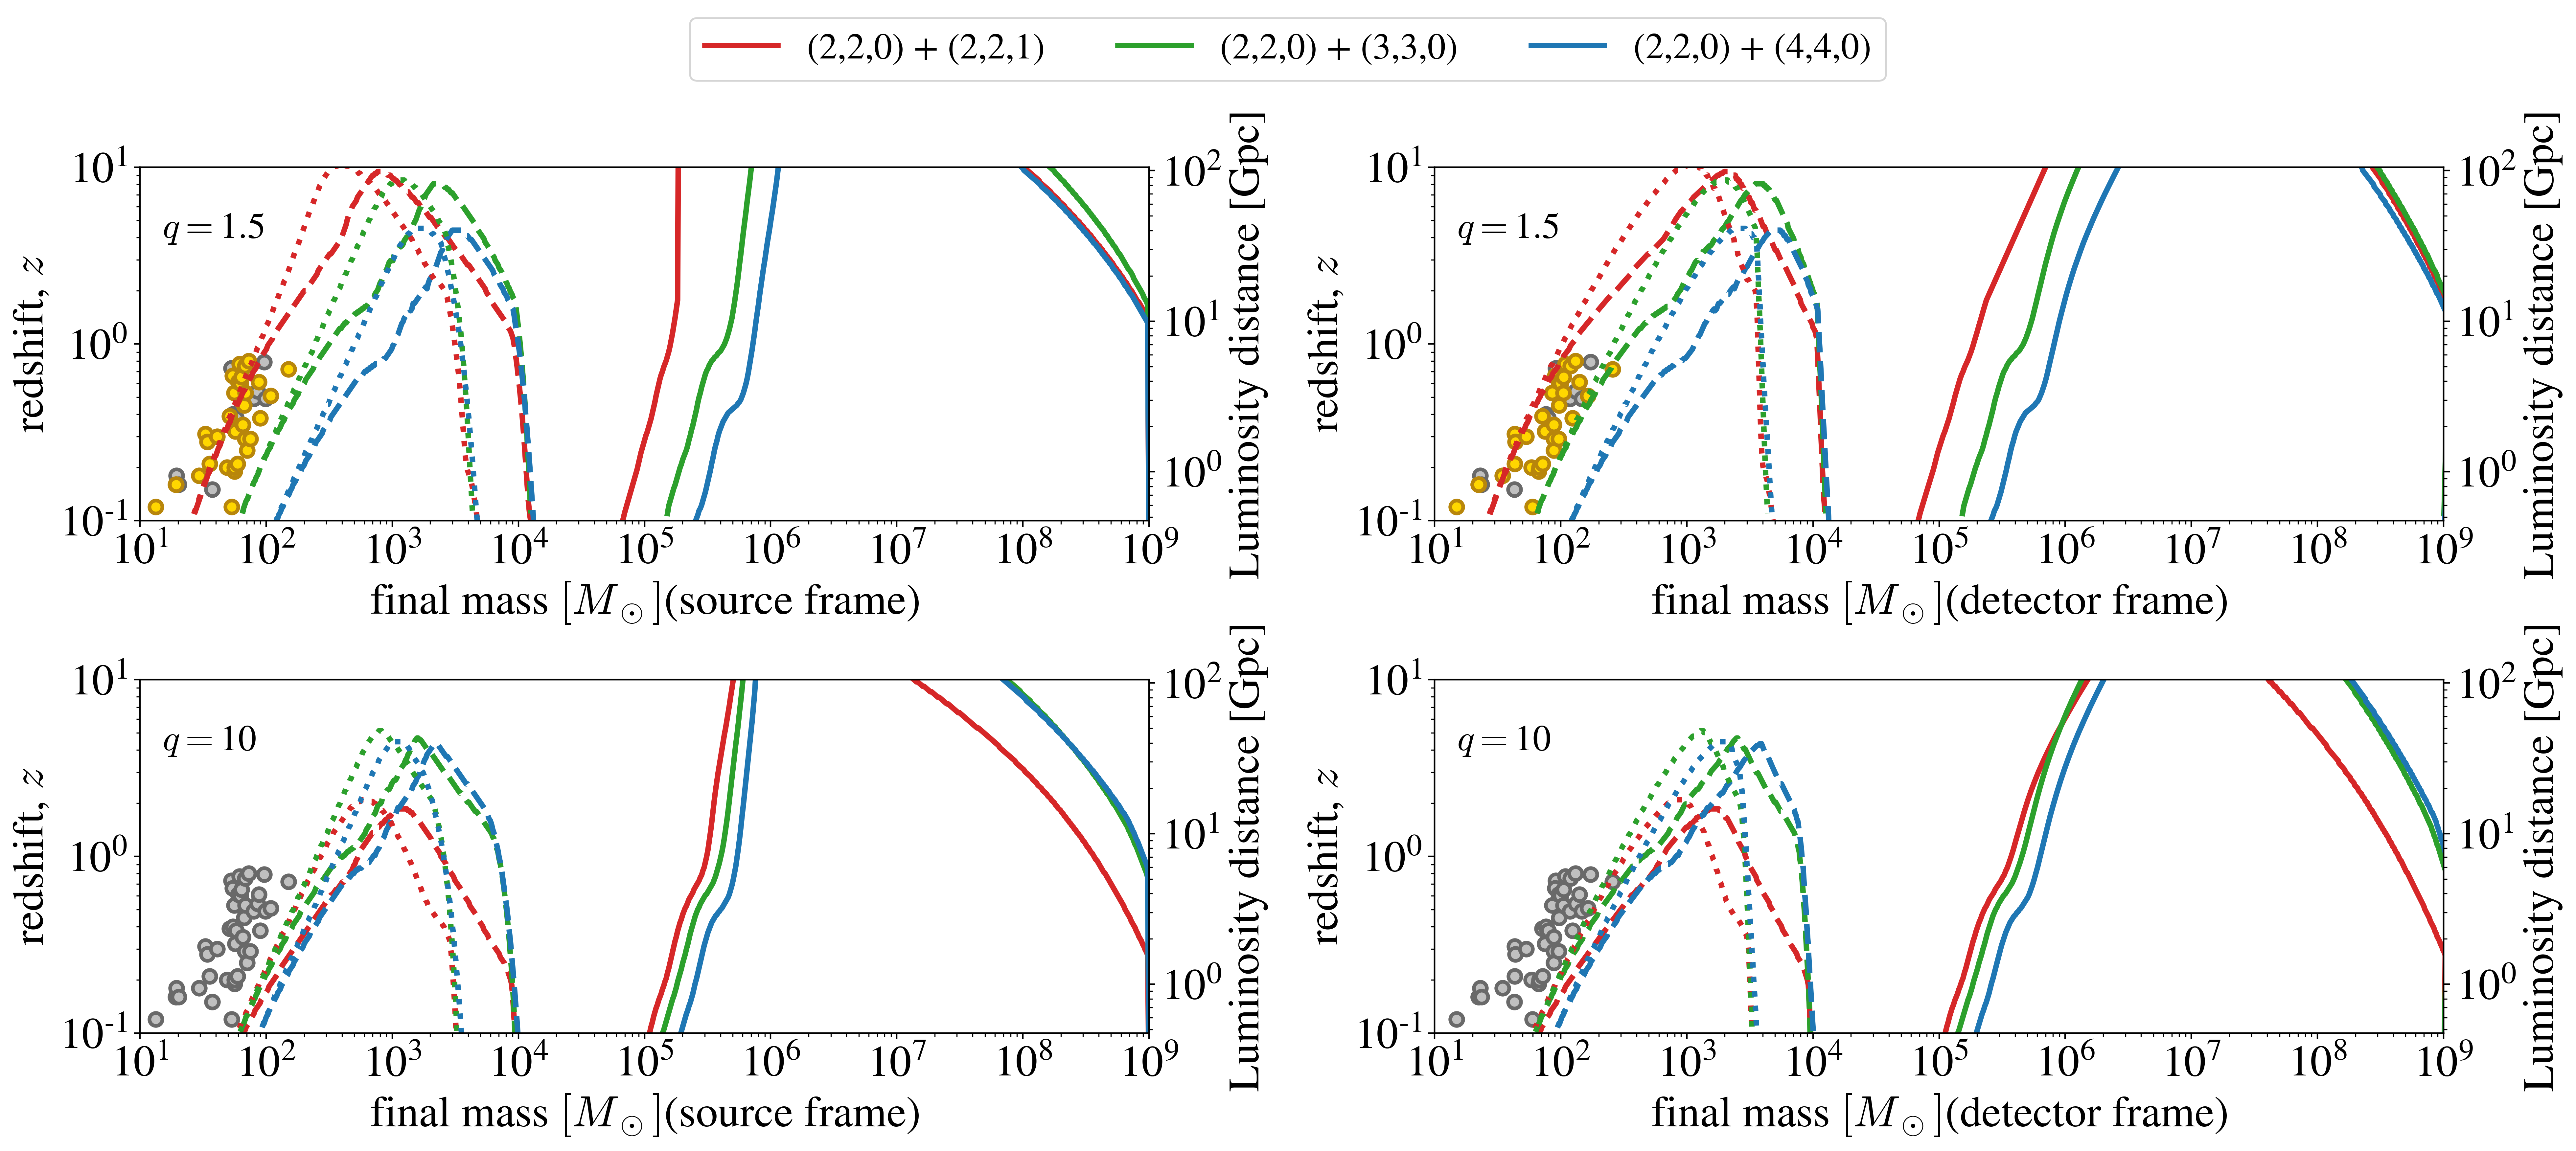

In [15]:
data_frame = pd.read_csv('../data/two_modes_horizons.dat', sep='\t')

plot_2_modes(data_frame)